In [18]:
import os
import torch
import torchmetrics
import torchvision
import numpy as np
from dataclasses import dataclass
from pathlib import Path
from torch import nn
from matplotlib import pyplot as plt
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader


%matplotlib inline

# Introduction

The goal of this exercise is to implement a machine learning project using PyTorch and its ecosystem of packages.

The task at hand is MNIST image classification, given a grayscale image of handwritten image, the task is to classify the image and determine which digit it represents from (0-9)

The neural network that we will implement is a simple Feed Forward Neural Network (FFNN)

In this exercise we will be using the following extra packages for PyTorch:

1. [`torchvision`](https://pytorch.org/vision/stable/index.html): computer vision utility functions and extensions for PyTroch
2. [`torchmetrics`](https://torchmetrics.readthedocs.io/en/stable/all-metrics.html): ready to use metrics for evaluating a machine learning model

## Instructions

1. Some tasks are already done for you, with a link to the related documentation left for your reference
2. Tasks that you're required to do are labeled with `TODO`
3. Use search engines and the official documentation as much as you can to gain better insights on the topics at hand

## Workflow

1. Prepare the dataset and data loaders
2. Explore the dataset visually
3. Define the model architecture
4. Prepare for training, by creating loss function, optimizer and metric function
5. Create training scripts and train
6. Validate the results visually

## Setup Device

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
print(device)

cpu


# Dataset

## Dataset 

In [12]:
# Create a local directory to store the dataset
data_dir = os.path.join(os.curdir, "data")
Path(data_dir).mkdir(exist_ok=True)

`torchvision` is part of PyTorch ecosystem, it has utilities for computer vision models.

We will first use the dataset submodule to import the *MNIST* dataset, you can find more details [here](https://pytorch.org/vision/stable/datasets.html)



In [13]:
# Create transform functions to apply to each image once it's downloaded
# REFERENCE: https://pytorch.org/vision/stable/transforms.html
transforms = torchvision.transforms.Compose(transforms=[
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: torch.flatten(x))
])

In [15]:
data_dir

'.\\data'

In [16]:
# TODO: Use torchvision datasets to load both MNSIT training and testing splits
# REFERENCE: https://pytorch.org/vision/stable/datasets.html
train_dataset = torchvision.datasets.MNIST(root=r'.\\data', train=True, download=True, transform=transforms)
test_dataset = torchvision.datasets.MNIST(root=r'.\\data', train=False, download=True, transform=transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .\\data\MNIST\raw\train-images-idx3-ubyte.gz to .\\data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .\\data\MNIST\raw\train-labels-idx1-ubyte.gz to .\\data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .\\data\MNIST\raw\t10k-images-idx3-ubyte.gz to .\\data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .\\data\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\\data\MNIST\raw



## DataLoader

In [19]:
# Define batch size
batch_size = 36

# TODO: Create dataloaders, allow shuffle and set the batch size to the defined variable
# REFERENCE: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size,
                          shuffle=True
                         )

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=True
                        )

## Exploration

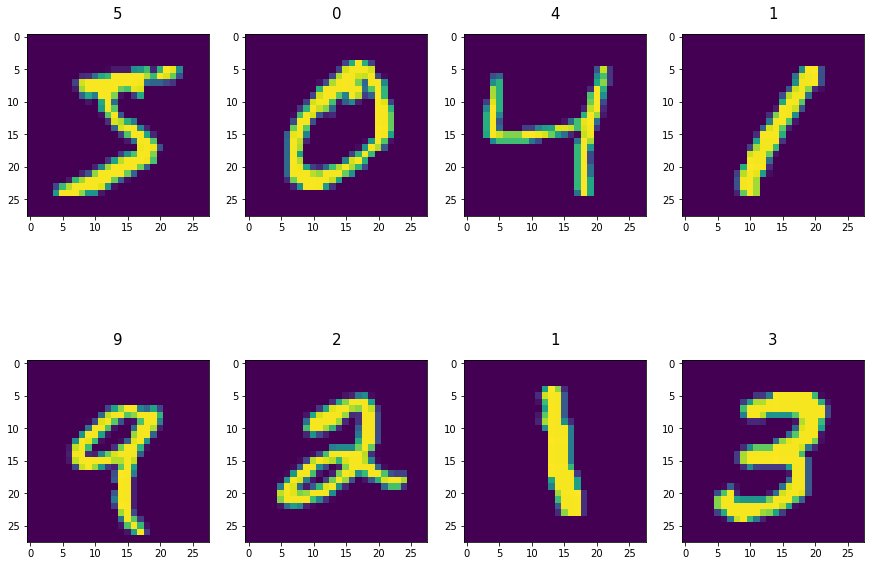

In [40]:
# Explore the dataset manually
samples = train_dataset.data[0:8]
labels = train_dataset.targets[0:8]

fig, axes = plt.subplots(figsize=(15, 10), nrows=2, ncols=4)

axes = np.array(axes).flatten()

for index, sample in enumerate(samples):
    axes[index].imshow(sample)
    axes[index].set_title(labels[index].item(), fontdict={"size": 15}, pad=15)
    

fig.subplots_adjust(hspace=0.5)

# Model

In [41]:
# The model class is created for you
# TODO: Define a three layer Feed Forward Neural Network (FFNN), 
# choose the input layer and output layer dimensions as appropriate, 
# and you can personally choose the hidden dimensions
class MNISTClassifier(nn.Module):
    def __init__(self, input_dim: int):
        super(MNISTClassifier, self).__init__()
        
        self.input_dim = input_dim
        
        self.fc1 = nn.Linear(in_features=self.input_dim, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
    
    # TODO: Define the fowrad function given an input image `x`
    # REMEMBER: To pass the input to a linear layer and apply an activation function of your choice afterwards
    # REMEMBER: The final output activation function is related to the loss function you'll use
    def forward(self, x):
        output = torch.relu(self.fc1(x)) 
        output = torch.relu(self.fc2(output))
        output = self.fc3(output)
        output = torch.log_softmax(output, dim=1)
        
        return output

In [42]:
# Instanciate the model class and move it to your device 
model = MNISTClassifier(input_dim=784)

# Training

In [43]:
# Define number of epochs for training
epochs = 5

# TODO: Define the optimizer, loss criterion
optim = torch.optim.Adam(params=model.parameters(), lr=1e-4)
critertion = nn.NLLLoss()
# TODO: Define a metric function (F1 Score) to evaluate the model
# REFERENCE: https://torchmetrics.readthedocs.io/en/stable/pages/overview.html
# REMEMBER: To move the metric function to the appropriate device
train_metric = torchmetrics.F1Score(num_classes=10)
val_metric = torchmetrics.F1Score(num_classes=10)

In [44]:
# A dataclass object defined to store the loss and metric results of each epoch
# REFERENCE: https://realpython.com/python-data-classes/
@dataclass
class Epoch:
    epoch: int
    training_loss: float
    validation_loss: float
    training_acc: float
    validation_acc: float
        
    def log(self) -> None:
        print(f"Epoch {self.epoch + 1}: Training Loss: {self.training_loss}\tValidation Loss: {self.validation_loss} || Training F1: {self.training_acc}\tValidation F1: {self.validation_acc}\n----------------------------------------------------")


Instructions for training script ***for each epoch***:

1. Set the initial epoch train and validation loss and metric to zero and reset the metric function
2. Set the model to training mode 
3. Load all batches in *train* dataloader
4. For each batch, unpack the inputs and target, move them to the correct device and pass them to the model to get predictions
5. Calculate loss and metric values for the prediction
6. Backpropagate the loss
7. Accumulate the epoch train loss and metric
8. Repeat the previous steps with appropriate changes to evaluate the model on the *test* data 
9. Store the epoch results in a history list

 

In [45]:
history: list[Epoch] = []

for epoch in range(epochs):
    # TODO: Define epoch train and test: loss and metrics
    # TODO: Make sure to reset the metric function
    epoch_train_loss = 0
    epoch_val_loss = 0
    
    train_metric.reset()
    val_metric.reset()
    
    # TODO: Set the model to training mode
    model.train()
    # Iterate train batches
    for batch in train_loader:
        
        # REMEMBER: you need to reset the optimizer in order to avoid incorrect accumulation of gradientrs 
        optim.zero_grad()
        
        # TODO: Unpack the batch and move it to the correct device
        inputs, target = batch
        inputs, target = inputs.to(device), target.to(device)

        # TODO: get prediction from model
        predictions = model(inputs)
        
        # TODO: Calculate loss and metric
        loss = critertion(predictions, target)
        train_metric(predictions, target)
        
        # TODO: Backward propagataion
        loss.backward()
        optim.step()
        
        # Accumulate train loss
        epoch_train_loss += loss.item()
    
    # Calculate epoch training metric
    epoch_train_f1 = round(train_metric.compute().item(), 3)

    
    # TODO: set the model to test mode
    model.eval()
    # Reset the metric function
    # Make sure PyTorch will run inference without tracking gradients for enhancing performance
    with torch.no_grad():
        # TODO: Load batches from `test_loader`
        for batch in test_loader:
            
            # TODO: Unpack the batch and move it to the correct device
            inputs, target = batch
            inputs, target = inputs.to(device), target.to(device)

            # TODO: get prediction from model
            predictions = model(inputs)
            
            # TODO: Calculate loss and metric values
            loss = critertion(predictions, target)
            val_metric(predictions, target)
            
            # TODO: Accumulate validation loss
            epoch_val_loss += loss.item()
            
        # TODO: Calculate epoch validation metric
        epoch_val_f1 = val_metric.compute()
      

    # Calculate epoch training loss
    epoch_train_loss = round(epoch_train_loss / len(train_loader), 3)
    # TODO: Calculate epoch validation loss
    epoch_val_loss = round(epoch_val_loss / len(train_loader), 3)
    
    # TODO: Create `Epoch` instance with the results
    epoch_result = Epoch(epoch=epoch, 
                         training_loss=epoch_train_loss, 
                         validation_loss=epoch_val_loss,
                         training_acc=epoch_train_f1,
                         validation_acc=epoch_val_f1,
                        )
    
    # Add to history list
    history.append(epoch_result)
    # Log epoch output
    epoch_result.log()

Epoch 1: Training Loss: 0.5	Validation Loss: 0.043 || Training F1: 0.874	Validation F1: 0.9248999953269958
----------------------------------------------------
Epoch 2: Training Loss: 0.226	Validation Loss: 0.032 || Training F1: 0.936	Validation F1: 0.9444000124931335
----------------------------------------------------
Epoch 3: Training Loss: 0.169	Validation Loss: 0.025 || Training F1: 0.952	Validation F1: 0.9541000127792358
----------------------------------------------------
Epoch 4: Training Loss: 0.133	Validation Loss: 0.021 || Training F1: 0.962	Validation F1: 0.9621000289916992
----------------------------------------------------
Epoch 5: Training Loss: 0.108	Validation Loss: 0.019 || Training F1: 0.969	Validation F1: 0.9652000069618225
----------------------------------------------------


## Training History

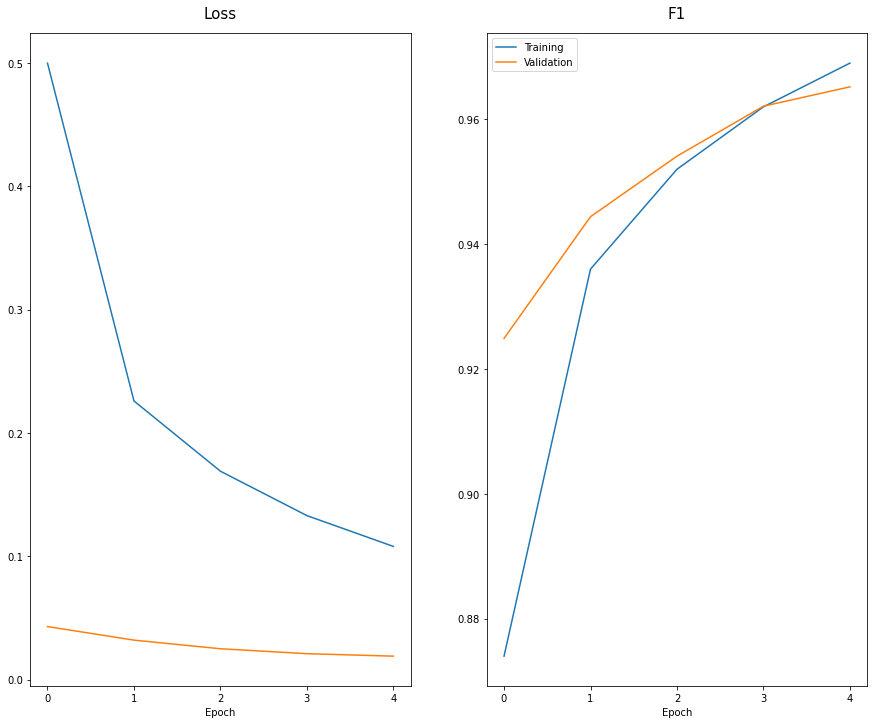

In [46]:
train_loss = list(map(lambda x: x.training_loss ,history))
val_loss = list(map(lambda x: x.validation_loss ,history))
train_acc = list(map(lambda x: x.training_acc, history))
val_acc = list(map(lambda x: x.validation_acc, history))

fig, (ax1, ax2) = plt.subplots(figsize=(15, 12), ncols=2)

ax1.plot(range(epochs), train_loss, label="Training")
ax1.plot(range(epochs), val_loss, label="Validation")

ax2.plot(range(epochs), train_acc, label="Training")
ax2.plot(range(epochs), val_acc, label="Validation")

ax1.set_title("Loss", fontdict=dict(size=15), pad=15)
ax2.set_title("F1", fontdict=dict(size=15), pad=15)

ax1.set_xticks(range(epochs))
ax2.set_xticks(range(epochs))

ax1.set_xlabel("Epoch")
ax2.set_xlabel("Epoch")

plt.legend()
plt.show()


# Visual Evaluation

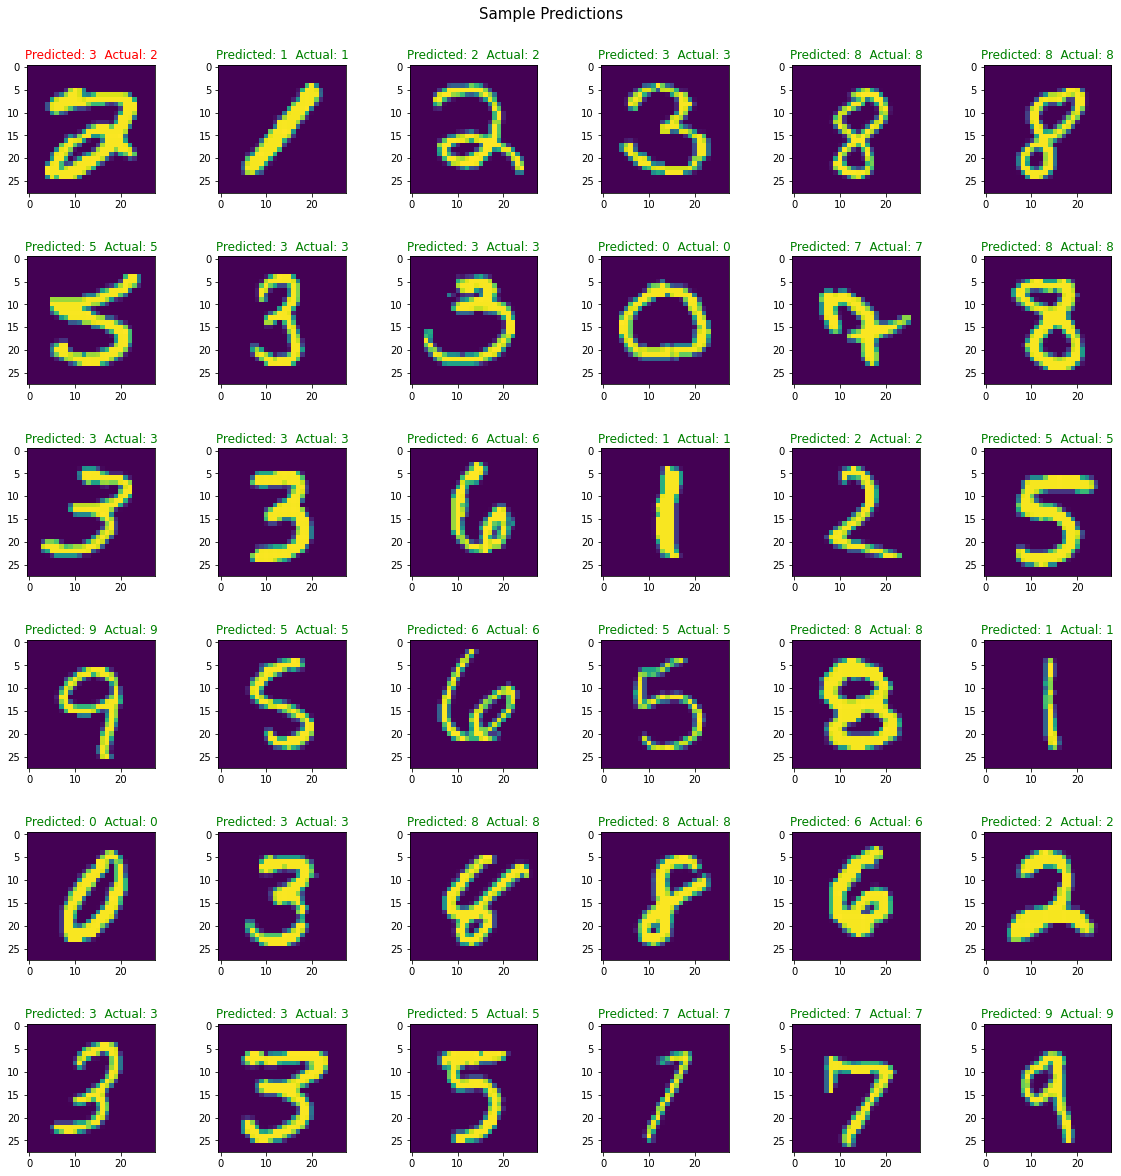

In [47]:
sample = next(iter(test_loader))
inputs, labels = sample


fig, axes = plt.subplots(figsize=(20, 20), ncols=6, nrows=6)

axes = np.array(axes).flatten()

model.eval()
for index in range(len(inputs)):
    im = inputs[index].unsqueeze(0)
    label = labels[index].item()
    
    prediction = model(im.to(device))
    prediction = torch.argmax(prediction).item()
    
    color = "green" if prediction == label else "red"
    axes[index].set_title(f"Predicted: {prediction}  Actual: {label}", color=color)
    
 
    axes[index].imshow(im.reshape((28, 28)))
    
    
fig.suptitle("Sample Predictions", y=0.92, fontsize=15)
fig.subplots_adjust(hspace=0.5)

# Extras

1. Train the model on the Fashion MNIST dataset
2. Create a deeper neural network
3. Try a different metric function

In [53]:
data_dir2 = os.path.join(os.curdir, "data2")
Path(data_dir).mkdir(exist_ok=True)

In [55]:
train_dataset1 = torchvision.datasets.FashionMNIST(root=r'.\\data2', train=True, download=True, transform=transforms)
test_dataset1 = torchvision.datasets.FashionMNIST(root=data_dir2, train=False, download=True, transform=transforms)

Using downloaded and verified file: .\\data2\FashionMNIST\raw\train-images-idx3-ubyte.gz
Extracting .\\data2\FashionMNIST\raw\train-images-idx3-ubyte.gz to .\\data2\FashionMNIST\raw

Using downloaded and verified file: .\\data2\FashionMNIST\raw\train-labels-idx1-ubyte.gz
Extracting .\\data2\FashionMNIST\raw\train-labels-idx1-ubyte.gz to .\\data2\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting .\\data2\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to .\\data2\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting .\\data2\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to .\\data2\FashionMNIST\raw



# Train the model on the Fashion MNIST dataset

In [56]:
batch_size = 36

train_loader1 = DataLoader(dataset=train_dataset1, 
                          batch_size=batch_size,
                          shuffle=True
                         )

test_loader1 = DataLoader(dataset=test_dataset1, 
                         batch_size=batch_size, 
                         shuffle=True
                        )

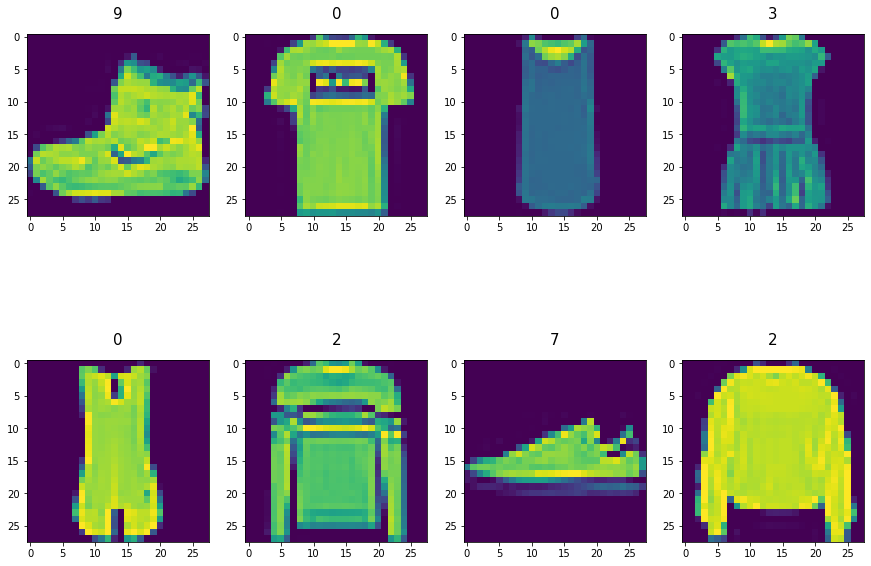

In [62]:
samples = train_dataset1.data[0:8]
labels = train_dataset1.targets[0:8]

fig, axes = plt.subplots(figsize=(15, 10), nrows=2, ncols=4)

axes = np.array(axes).flatten()

for index, sample in enumerate(samples):
    axes[index].imshow(sample)
    axes[index].set_title(labels[index].item(), fontdict={"size": 15}, pad=15)
    

fig.subplots_adjust(hspace=0.5)

In [64]:
model = MNISTClassifier(input_dim=784)

In [65]:
epochs = 5

optim = torch.optim.Adam(params=model.parameters(), lr=1e-4)
critertion = nn.NLLLoss()
train_metric = torchmetrics.F1Score(num_classes=10)
val_metric = torchmetrics.F1Score(num_classes=10)

In [66]:
@dataclass
class Epoch:
    epoch: int
    training_loss: float
    validation_loss: float
    training_acc: float
    validation_acc: float
        
    def log(self) -> None:
        print(f"Epoch {self.epoch + 1}: Training Loss: {self.training_loss}\tValidation Loss: {self.validation_loss} || Training F1: {self.training_acc}\tValidation F1: {self.validation_acc}\n----------------------------------------------------")


In [68]:
history: list[Epoch] = []

for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0
    
    train_metric.reset()
    val_metric.reset()
    model.train()
    for batch in train_loader1:
        optim.zero_grad()
        
        inputs, target = batch
        inputs, target = inputs.to(device), target.to(device)
        predictions = model(inputs)
        loss = critertion(predictions, target)
        train_metric(predictions, target)
        loss.backward()
        optim.step()
        epoch_train_loss += loss.item()
    epoch_train_f1 = round(train_metric.compute().item(), 3)
    model.eval()
    with torch.no_grad():
        for batch in test_loader1:
            inputs, target = batch
            inputs, target = inputs.to(device), target.to(device)
            predictions = model(inputs)
            loss = critertion(predictions, target)
            val_metric(predictions, target)
            epoch_val_loss += loss.item()
        epoch_val_f1 = val_metric.compute()

    epoch_train_loss = round(epoch_train_loss / len(train_loader1), 3)
    epoch_val_loss = round(epoch_val_loss / len(train_loader1), 3)
    epoch_result = Epoch(epoch=epoch, training_loss=epoch_train_loss, validation_loss=epoch_val_loss,
                         training_acc=epoch_train_f1, validation_acc=epoch_val_f1,)
    
    history.append(epoch_result)
    epoch_result.log()

Epoch 1: Training Loss: 0.621	Validation Loss: 0.081 || Training F1: 0.796	Validation F1: 0.8288000226020813
----------------------------------------------------
Epoch 2: Training Loss: 0.416	Validation Loss: 0.07 || Training F1: 0.855	Validation F1: 0.8514000177383423
----------------------------------------------------
Epoch 3: Training Loss: 0.372	Validation Loss: 0.068 || Training F1: 0.868	Validation F1: 0.8536999821662903
----------------------------------------------------
Epoch 4: Training Loss: 0.343	Validation Loss: 0.063 || Training F1: 0.878	Validation F1: 0.8677000403404236
----------------------------------------------------
Epoch 5: Training Loss: 0.32	Validation Loss: 0.059 || Training F1: 0.885	Validation F1: 0.8740000128746033
----------------------------------------------------


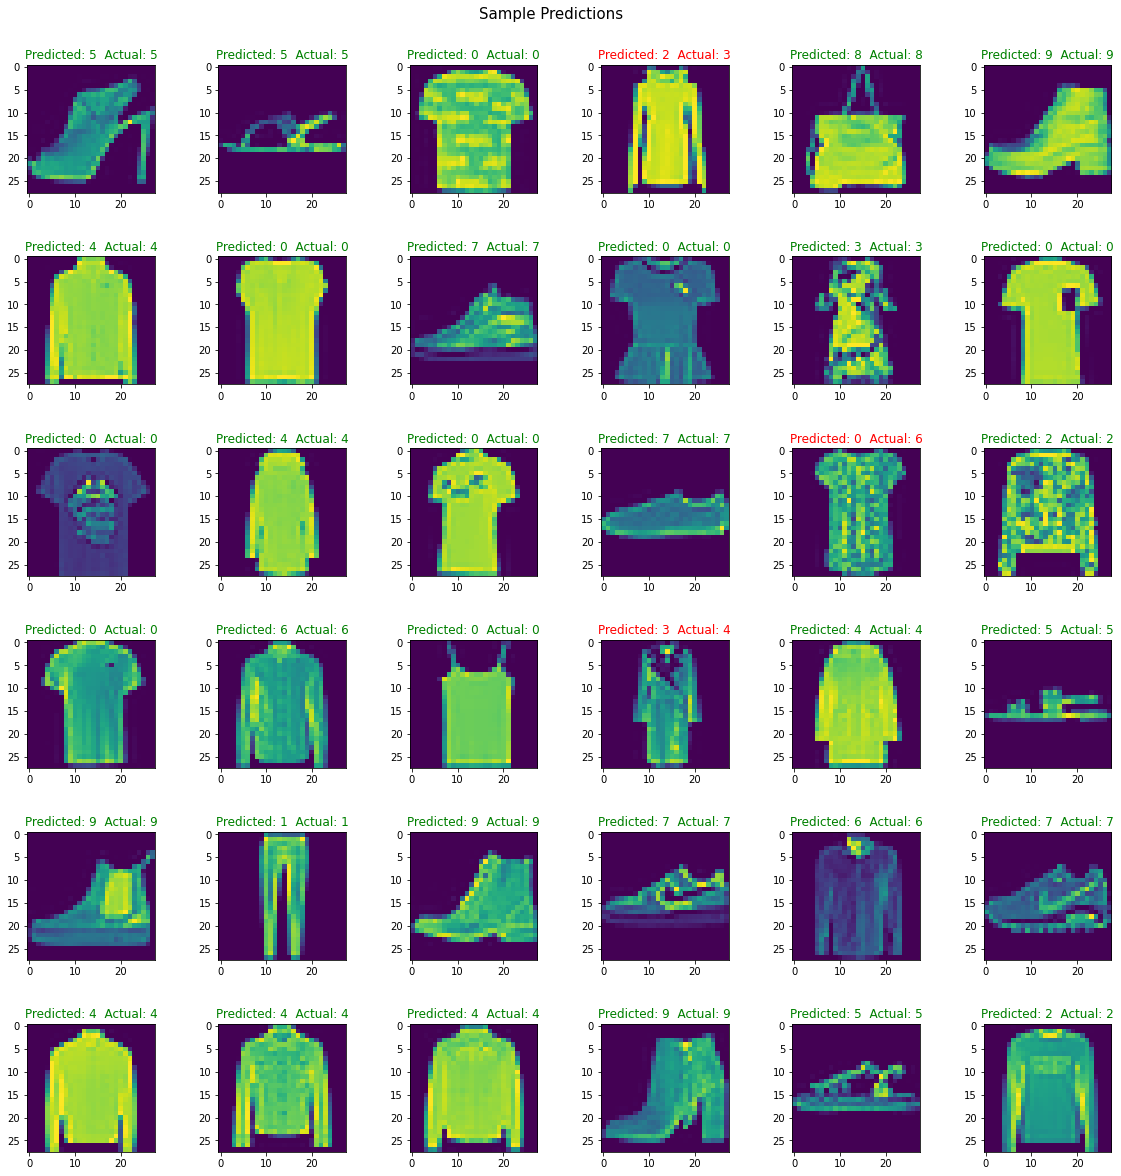

In [71]:
sample = next(iter(test_loader1))
inputs, labels = sample


fig, axes = plt.subplots(figsize=(20, 20), ncols=6, nrows=6)

axes = np.array(axes).flatten()

model.eval()
for index in range(len(inputs)):
    im = inputs[index].unsqueeze(0)
    label = labels[index].item()
    
    prediction = model(im.to(device))
    prediction = torch.argmax(prediction).item()
    
    color = "green" if prediction == label else "red"
    axes[index].set_title(f"Predicted: {prediction}  Actual: {label}", color=color)
    
 
    axes[index].imshow(im.reshape((28, 28)))
    
    
fig.suptitle("Sample Predictions", y=0.92, fontsize=15)
fig.subplots_adjust(hspace=0.5)

# Create a deeper neural network

In [ ]:
# class MNISTClassifierDeeper(nn.Module):
    def __init__(self, input_dim: int):
        super(MNISTClassifierDeeper, self).__init__()
        
        self.input_dim = input_dim
        
        self.fc1 = nn.Linear(in_features=self.input_dim, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=128)
        self.fc4 = nn.Linear(in_features=128, out_features=10)
    def forward(self, x):
        output = torch.relu(self.fc1(x)) 
        output = torch.relu(self.fc2(output))
        output = torch.relu(self.fc3(output))
        output = self.fc4(output)
        output = torch.log_softmax(output, dim=1)
        
        return output

In [103]:
model = MNISTClassifierDeeper(input_dim=784)

In [104]:
epochs = 5

optim = torch.optim.Adam(params=model.parameters(), lr=1e-4)
critertion = nn.NLLLoss()
train_metric = torchmetrics.F1Score(num_classes=10)
val_metric = torchmetrics.F1Score(num_classes=10)
@dataclass
class Epoch:
    epoch: int
    training_loss: float
    validation_loss: float
    training_acc: float
    validation_acc: float
        
    def log(self) -> None:
        print(f"Epoch {self.epoch + 1}: Training Loss: {self.training_loss}\tValidation Loss: {self.validation_loss} || Training F1: {self.training_acc}\tValidation F1: {self.validation_acc}\n----------------------------------------------------")


In [105]:
history: list[Epoch] = []

for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0
    
    train_metric.reset()
    val_metric.reset()
    model.train()
    for batch in train_loader1:
        optim.zero_grad()
        
        inputs, target = batch
        inputs, target = inputs.to(device), target.to(device)
        predictions = model(inputs)
        loss = critertion(predictions, target)
        train_metric(predictions, target)
        loss.backward()
        optim.step()
        epoch_train_loss += loss.item()
    epoch_train_f1 = round(train_metric.compute().item(), 3)
    model.eval()
    with torch.no_grad():
        for batch in test_loader1:
            inputs, target = batch
            inputs, target = inputs.to(device), target.to(device)
            predictions = model(inputs)
            loss = critertion(predictions, target)
            val_metric(predictions, target)
            epoch_val_loss += loss.item()
        epoch_val_f1 = val_metric.compute()

    epoch_train_loss = round(epoch_train_loss / len(train_loader1), 3)
    epoch_val_loss = round(epoch_val_loss / len(train_loader1), 3)
    epoch_result = Epoch(epoch=epoch, training_loss=epoch_train_loss, validation_loss=epoch_val_loss,
                         training_acc=epoch_train_f1, validation_acc=epoch_val_f1,)
    
    history.append(epoch_result)
    epoch_result.log()

Epoch 1: Training Loss: 0.672	Validation Loss: 0.083 || Training F1: 0.767	Validation F1: 0.8274000287055969
----------------------------------------------------
Epoch 2: Training Loss: 0.438	Validation Loss: 0.072 || Training F1: 0.846	Validation F1: 0.8449000120162964
----------------------------------------------------
Epoch 3: Training Loss: 0.393	Validation Loss: 0.068 || Training F1: 0.861	Validation F1: 0.8557000160217285
----------------------------------------------------
Epoch 4: Training Loss: 0.366	Validation Loss: 0.065 || Training F1: 0.869	Validation F1: 0.8632000088691711
----------------------------------------------------
Epoch 5: Training Loss: 0.343	Validation Loss: 0.063 || Training F1: 0.878	Validation F1: 0.8634000420570374
----------------------------------------------------


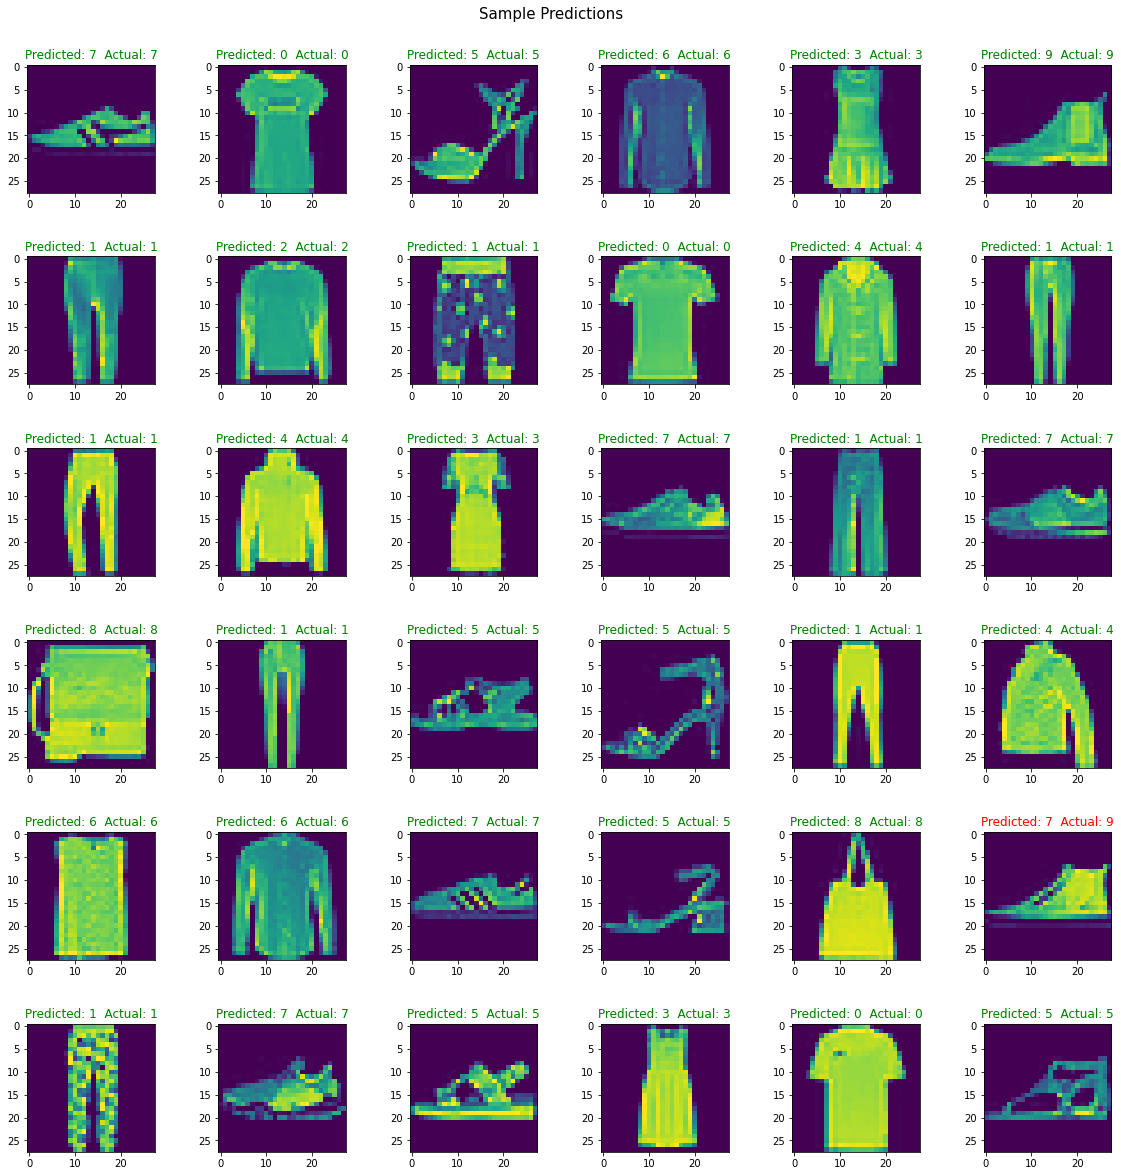

In [108]:
sample = next(iter(test_loader1))
inputs, labels = sample


fig, axes = plt.subplots(figsize=(20, 20), ncols=6, nrows=6)

axes = np.array(axes).flatten()

model.eval()
for index in range(len(inputs)):
    im = inputs[index].unsqueeze(0)
    label = labels[index].item()
    
    prediction = model(im.to(device))
    prediction = torch.argmax(prediction).item()
    
    color = "green" if prediction == label else "red"
    axes[index].set_title(f"Predicted: {prediction}  Actual: {label}", color=color)
    
 
    axes[index].imshow(im.reshape((28, 28)))
    
    
fig.suptitle("Sample Predictions", y=0.92, fontsize=15)
fig.subplots_adjust(hspace=0.5)